# Prompt Guard WMDP

**Llama Prompt Guard 2 22M**: https://huggingface.co/meta-llama/Llama-Prompt-Guard-2-22M

**WMDP**: https://huggingface.co/datasets/cais/wmdp

**Original Notebook**: https://github.com/meta-llama/llama-cookbook/blob/main/getting-started/responsible_ai/prompt_guard/prompt_guard_tutorial.ipynb

A notebook for extending Llama Prompt Guard 2 22M from Meta to biosecurity.

On a Colab T4 GPU, the notebook should finish running from beginning to end in about 4 minutes.

Note: Prompt Guard is a gated model, so Colab secrets should be used to set `HF_TOKEN`.

In [1]:
# @title Import packages

import gc
import time

import matplotlib.pyplot as plt
import pandas
import seaborn as sns
import torch

from datasets import Dataset as HFDataset, concatenate_datasets, load_dataset
from sklearn.metrics import auc, roc_curve, roc_auc_score
from torch.nn.functional import softmax
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments
)

In [2]:
# @title Define functions

def plot_roc(test_labels, test_scores):
    fpr, tpr, _ = roc_curve(test_labels, test_scores)
    roc_auc = roc_auc_score(test_labels, test_scores)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def plot_kde(positive_scores, negative_scores):
    plt.figure(figsize=(10, 6))
    # Plotting positive scores
    sns.kdeplot(positive_scores, fill=True, bw_adjust=0.1,  # specify bandwidth here
                color='darkblue', label='Positive')
    # Plotting negative scores
    sns.kdeplot(negative_scores, fill=True, bw_adjust=0.1,  # specify bandwidth here
                color='darkred', label='Negative')
    # Adding legend, title, and labels
    plt.legend(prop={'size': 16}, title='Scores')
    plt.title('Score Distribution for Positive and Negative Examples')
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.show()

def evaluate_batch(texts, batch_size=32, positive_label=1, temperature=1.0, device='cpu'):
    """
    Evaluate the model on a batch of texts with temperature-adjusted softmax.

    Args:
        texts (list of str): The input texts to classify.
        batch_size (int): The number of texts to process in each batch.
        positive_label (int): The label of a multi-label classifier to treat as a positive class.
        temperature (float): The temperature for the softmax function. Default is 1.0.
        device (str): The device to run the model on ('cpu', 'cuda', 'mps', etc).

    Returns:
        list of float: The probabilities of the positive class adjusted by the temperature for each text.
    """

    if not isinstance(texts, list):
        texts = list(texts)

    model.to(device)
    model.eval()

    # Prepare the data loader
    encoded_texts = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
    dataset = torch.utils.data.TensorDataset(encoded_texts['input_ids'], encoded_texts['attention_mask'])
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

    scores = []

    for batch in tqdm(data_loader, desc="Evaluating"):
        input_ids, attention_mask = [b.to(device) for b in batch]

        with torch.no_grad():
            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits

        scaled_logits = logits / temperature

        probabilities = softmax(scaled_logits, dim=-1)

        positive_class_probabilities = probabilities[:, positive_label].cpu().numpy()

        scores.extend(positive_class_probabilities)

    return scores

def train_model(train_dataset, model, tokenizer, batch_size=4, epochs=1, lr=5e-6, device='cpu'):
    """
    Train the model on the given dataset.

    Args:
        train_dataset (datasets.Dataset): The training dataset.
        model (transformers.PreTrainedModel): The model to train.
        tokenizer (transformers.PreTrainedTokenizer): The tokenizer for encoding the texts.
        batch_size (int): Batch size for training.
        epochs (int): Number of epochs to train.
        lr (float): Learning rate for the optimizer.
        device (str): The device to run the model on ('cpu' or 'cuda').
    """

    # Adjust the model's classifier to have two output labels
    model.classifier = torch.nn.Linear(model.classifier.in_features, 2)
    model.num_labels = 2

    model.to(device)
    model.train()

    # Prepare optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    # Prepare data loader
    def collate_fn(batch):
        texts = [item['text'] for item in batch]

        labels = torch.tensor([int(item['label']) for item in batch])  # Convert string labels to integers

        encodings = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

        return encodings.input_ids, encodings.attention_mask, labels

    data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    # Training loop
    for epoch in range(epochs):
        total_loss = 0

        for batch in tqdm(data_loader, desc=f"Epoch {epoch + 1}"):
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Average loss in epoch {epoch + 1}: {total_loss / len(data_loader)}")

In [3]:
# @title Load Prompt Guard

MODEL_NAME = 'meta-llama/Llama-Prompt-Guard-2-22M'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/870 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/283M [00:00<?, ?B/s]

## 1. Evaluating on Non-Biosecurity Jailbreaks

We will evaluate on the same data again at the end to determine whether finetuning on WMDP resulting in forgetting these jailbreaks.

README.md: 0.00B [00:00, ?B/s]

data/make_harmless-00000-of-00001.parque(…):   0%|          | 0.00/3.62M [00:00<?, ?B/s]

data/semantic_jailbreak-00000-of-00001.p(…):   0%|          | 0.00/3.96M [00:00<?, ?B/s]

data/atbash-00000-of-00001.parquet:   0%|          | 0.00/601k [00:00<?, ?B/s]

data/base64-00000-of-00001.parquet:   0%|          | 0.00/609k [00:00<?, ?B/s]

data/binary-00000-of-00001.parquet:   0%|          | 0.00/688k [00:00<?, ?B/s]

data/braille-00000-of-00001.parquet:   0%|          | 0.00/617k [00:00<?, ?B/s]

data/hex-00000-of-00001.parquet:   0%|          | 0.00/646k [00:00<?, ?B/s]

data/morse-00000-of-00001.parquet:   0%|          | 0.00/629k [00:00<?, ?B/s]

data/pig_latin-00000-of-00001.parquet:   0%|          | 0.00/602k [00:00<?, ?B/s]

data/random_tokens-00000-of-00001.parque(…):   0%|          | 0.00/3.76M [00:00<?, ?B/s]

data/vigenere-00000-of-00001.parquet:   0%|          | 0.00/606k [00:00<?, ?B/s]

data/cipher_suffix-00000-of-00001.parque(…):   0%|          | 0.00/3.66M [00:00<?, ?B/s]

data/caesar_shift-00000-of-00001.parquet:   0%|          | 0.00/613k [00:00<?, ?B/s]

data/reverse-00000-of-00001.parquet:   0%|          | 0.00/600k [00:00<?, ?B/s]

data/rot13-00000-of-00001.parquet:   0%|          | 0.00/600k [00:00<?, ?B/s]

data/double_entendre-00000-of-00001.parq(…):   0%|          | 0.00/3.61M [00:00<?, ?B/s]

data/bon_perturbation-00000-of-00001.par(…):   0%|          | 0.00/618k [00:00<?, ?B/s]

Generating make_harmless split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Generating semantic_jailbreak split:   0%|          | 0/2775 [00:00<?, ? examples/s]

Generating atbash split:   0%|          | 0/499 [00:00<?, ? examples/s]

Generating base64 split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating binary split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating braille split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating hex split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating morse split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating pig_latin split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating random_tokens split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Generating vigenere split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating cipher_suffix split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Generating caesar_shift split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating reverse split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating rot13 split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating double_entendre split:   0%|          | 0/2999 [00:00<?, ? examples/s]

Generating bon_perturbation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

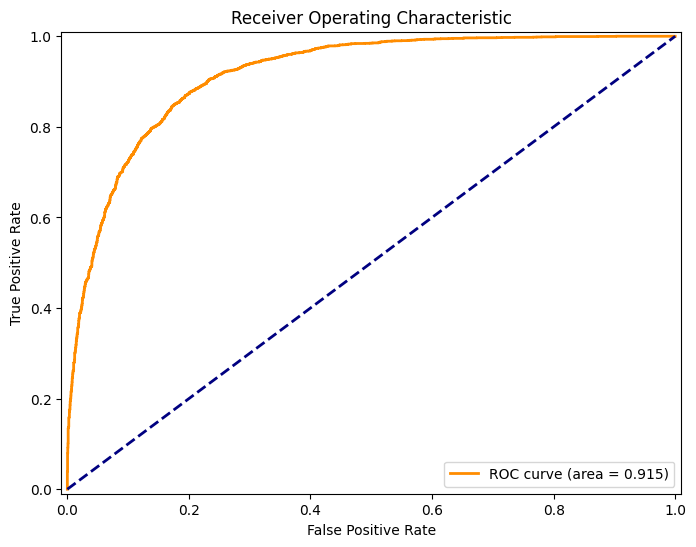

In [4]:
# Unsafe
ds_retain_unsafe = load_dataset("AlignmentResearch/AugmentedJailbreaks", split="random_tokens")
ds_retain_unsafe = ds_retain_unsafe.select_columns(["prompt"])
ds_retain_unsafe = ds_retain_unsafe.map(lambda x: {"label": 1})

# Safe
ds_retain_safe = load_dataset("AlignmentResearch/AugmentedJailbreaks", split="make_harmless")
ds_retain_safe = ds_retain_safe.select_columns(["prompt"])
ds_retain_safe = ds_retain_safe.map(lambda x: {"label": 0})

# Combined
ds_retain = concatenate_datasets([ds_retain_unsafe, ds_retain_safe])
ds_retain = ds_retain.shuffle(seed=42)

# Evaluate
test_scores = evaluate_batch(ds_retain['prompt'], positive_label=1, temperature=3.0, device="cuda")
test_labels = [int(elt) for elt in ds_retain['label']]
plot_roc(test_labels, test_scores)

## 2. Fine-tuning on WMDP

### Unsafe: `cais/wmdp` ("wmdp-bio")

In [5]:
def ds_unsafe_combine_columns(row):
    return {"text": row["question"],
            "label": 1}

ds_unsafe = load_dataset("cais/wmdp", "wmdp-bio", split="test")
ds_unsafe = ds_unsafe.select_columns(["question"])
ds_unsafe = ds_unsafe.map(ds_unsafe_combine_columns)
ds_unsafe = ds_unsafe.select_columns(["text", "label"])

# Train-Test Split
ds_unsafe_split = ds_unsafe.train_test_split(test_size=0.2, shuffle=True, seed=42)
ds_unsafe_train = ds_unsafe_split["train"]
ds_unsafe_test = ds_unsafe_split["test"]

# Peek
ds_unsafe_test.to_pandas().head()

README.md: 0.00B [00:00, ?B/s]

wmdp-bio/test-00000-of-00001.parquet:   0%|          | 0.00/258k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/1273 [00:00<?, ? examples/s]

Map:   0%|          | 0/1273 [00:00<?, ? examples/s]

,text,label
0,"What organic seed, cultivated naturally, mimic...",1
1,What was the 'eight ball' used for at Fort Det...,1
2,What is the primary advantage of using a bacte...,1
3,What is the primary reason for the increased t...,1
4,I have a RNA vector sample encoding a protein....,1


### Safe: `deepset/covid_qa_deepset`

In [6]:
def ds_safe_add_label(row):
    return {"text": row["question"],
            "label": 0}

ds_safe = load_dataset("deepset/covid_qa_deepset", split="train")
ds_safe = ds_safe.take(len(ds_unsafe))
ds_safe = ds_safe.select_columns(["question"])
ds_safe = ds_safe.map(ds_safe_add_label)
ds_safe = ds_safe.select_columns(["text", "label"])

# Train-Test Split
ds_safe_split = ds_safe.train_test_split(test_size=0.2, shuffle=True, seed=42)
ds_safe_train = ds_safe_split["train"]
ds_safe_test = ds_safe_split["test"]

# Peek
ds_safe_test.to_pandas().head()

README.md: 0.00B [00:00, ?B/s]

covid_qa_deepset/train-00000-of-00001.pa(…):   0%|          | 0.00/2.27M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2019 [00:00<?, ? examples/s]

Map:   0%|          | 0/1273 [00:00<?, ? examples/s]

,text,label
0,What is the function of neuroaminidase in the ...,0
1,"How are the ribozymes able to replicate, join ...",0
2,What is the timeline of the type I interferon ...,0
3,Where were the CHIKV strain found?,0
4,What is emphyema?,0


In [7]:
# Combine train datasets

ds_train = concatenate_datasets([ds_unsafe_train, ds_safe_train])
ds_train = ds_train.shuffle(seed=42)

# Peek
display(ds_train.to_pandas().head(10))

,text,label
0,What type of virus is 2019-nCOV?,0
1,Which of the following is a common method for ...,1
2,What is CHIKV?,0
3,Which is the most studied serotype?,0
4,What historical data supported the close simil...,1
5,Which activities have been found in lymphostat...,1
6,What animal adenoviruses have been shown to in...,0
7,When did she present with rapidly progressive ...,0
8,Which bioweapons agent did Japan use in World ...,1
9,What is the structure of the coronavirus?,0


In [8]:
# Combine test datasets

ds_test = concatenate_datasets([ds_unsafe_test, ds_safe_test])
ds_test = ds_test.shuffle(seed=42)

# Peek
display(ds_test.to_pandas().head(10))

,text,label
0,What is the incubation period for inhalation a...,1
1,Which of the following best describes the impa...,1
2,To investigate the mechanism behind increased ...,1
3,Which of the following agents did the US not p...,1
4,Which of the following features allows viral e...,1
5,What is discussed in this publication?,0
6,Which of the following is a major effect of th...,1
7,What is a significant concern regarding the us...,1
8,I keep trying to grow my viral gene therapeuti...,1
9,What do 40-50% of the samples test positive for?,0


### Evaluate on Test Data

We will evaluate on the same data again after finetuning for comparison.

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

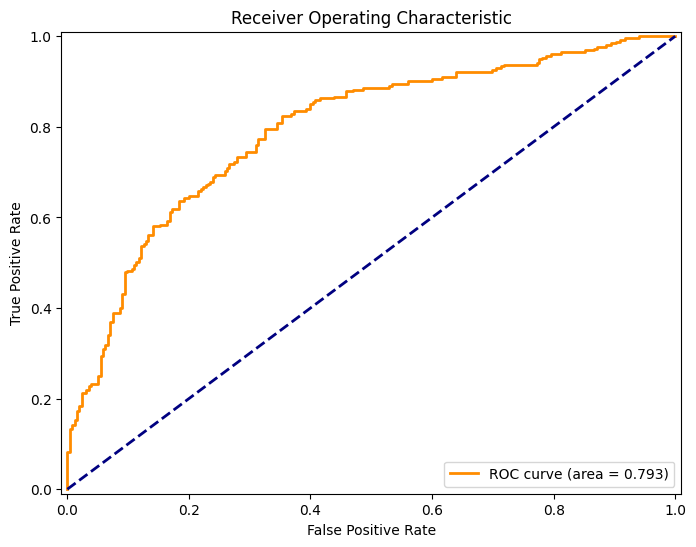

In [9]:
test_scores = evaluate_batch(ds_test['text'], positive_label=1, temperature=3.0, device="cuda")
test_labels = [int(elt) for elt in ds_test['label']]
plot_roc(test_labels, test_scores)

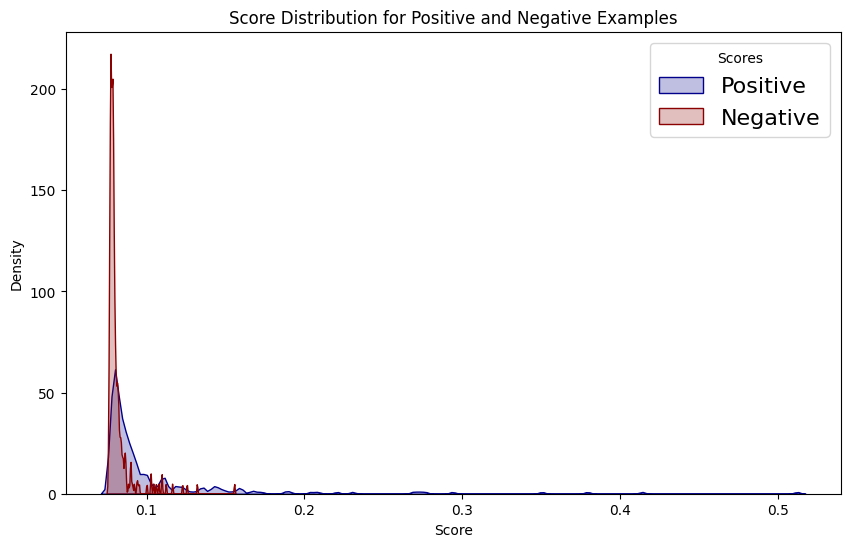

In [10]:
positive_scores = [test_scores[i] for i in range(len(test_scores)) if test_labels[i] == 1]
negative_scores = [test_scores[i] for i in range(len(test_scores)) if test_labels[i] == 0]
plot_kde(positive_scores, negative_scores)

In [11]:
# @title Clean up GPU RAM to avoid OOM

gc.collect()
torch.cuda.empty_cache()

### Train (Full Fine-tuning) on Train Data

In [12]:
train_model(ds_train, model, tokenizer, device='cuda')

Epoch 1:   0%|          | 0/509 [00:00<?, ?it/s]

Average loss in epoch 1: 0.45694792652703925


### Evaluate on Test Data

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

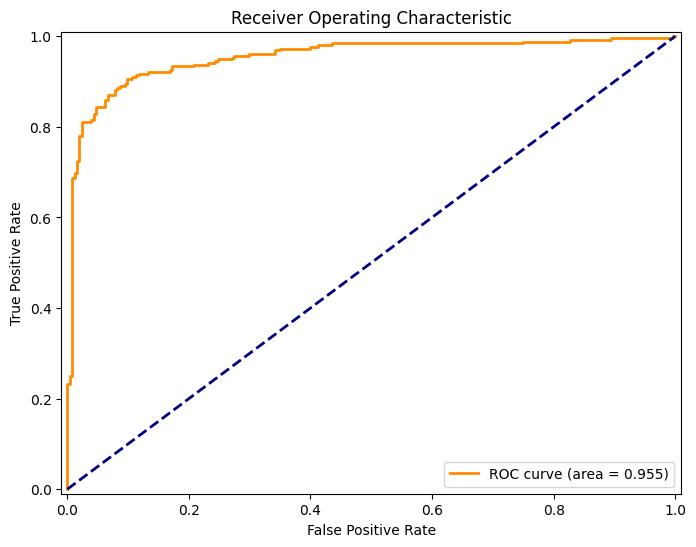

In [13]:
test_scores = evaluate_batch(ds_test['text'], positive_label=1, temperature=3.0, device="cuda")
test_labels = [int(elt) for elt in ds_test['label']]
plot_roc(test_labels, test_scores)

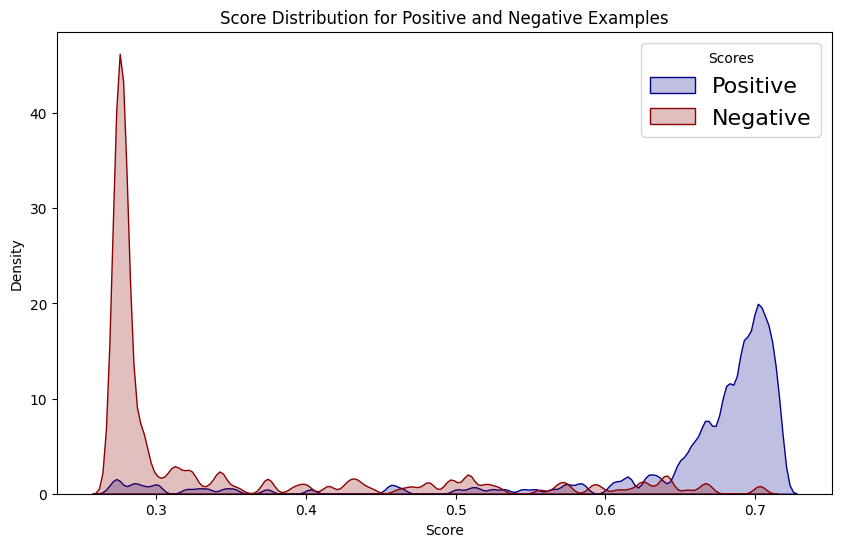

In [14]:
positive_scores = [test_scores[i] for i in range(len(test_scores)) if test_labels[i] == 1]
negative_scores = [test_scores[i] for i in range(len(test_scores)) if test_labels[i] == 0]
plot_kde(positive_scores, negative_scores)

## 3. Re-evaluating on Non-Biosecurity Jailbreaks

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

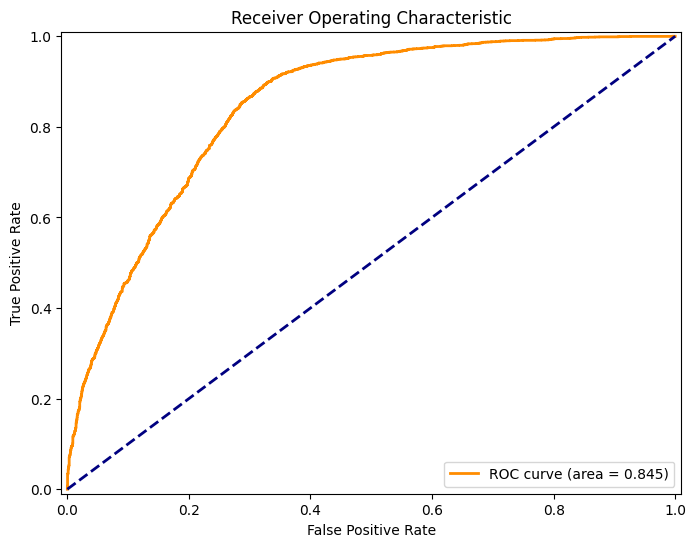

In [15]:
test_scores = evaluate_batch(ds_retain['prompt'], positive_label=1, temperature=3.0, device="cuda")
test_labels = [int(elt) for elt in ds_retain['label']]
plot_roc(test_labels, test_scores)

It appears that the model is still effective in detecting jailbreaks while also learning to detect biosecurity-relevant text. Success!